# Modelado AR (estimación de espectro AR y residuos)

Ignacio Díaz Blanco, 2019. Universidad de Oviedo

## Descripción del método
Este script describe un ejemplo de *estimación espectral*. Concretamente, del espectro autorregresivo (AR) de orden *n* de una señal. La idea consiste en describir la señal en el instante $k$ en términos de sus valores en los instantes anteriores $k-1, k-2, \dots, k-n$ más un término de error, $\nu_k$ que si el modelo fuera exacto sería ruido blanco (incorrelado).

$$
y_k = a_1 y_{k-1} + a_2 y_{k-2} + \dots + a_n y_{k-n} + \nu_k
$$

En términos de la transformada $Z$ esto equivale

$$
Y(z) = a_1 z^{-1}Y(z) + a_2 z^{k-2}Y(z) + \dots + a_n z^{k-n}Y(z) + \nu(z)
$$

o bien (pasando los retrasos al otro miembro) y tomando transformadas $z$

$$
Y(z) = \frac{1}{1-a_1 z^{-1}-a_2 z^{-2}-\dots-a_n z^{-n}} \nu_(z) \quad \rightarrow \quad Y(z) = \frac{1}{A(z)}\nu(z)
$$

En la hipótesis de que $\nu_k$ es ruido blanco, su espectro es constante e igual a todas las frecuencias, siendo el espectro definido por $kte/A(z)$, donde $kte$ debe ser determinada posteriormente. Así, es posible determinar el espectro de la señal *visualizando el espectro del modelo paramétrico que la genera*


$$
{\rm Espectro\, de\, } y:\, Y(e^{j\theta}) \approx \frac{1}{A(e^{j\theta})}
$$


## Aplicación industrial
Estimamos el espectro AR a partir de datos "normales" (ensayo 2 de dataicann). Luego aplicamos el modelo AR a ese y otros ensayos y comparamos sus predicciones con los valores reales. Los residuos resultantes muestran el grado de discrepancia del contenido frecuencial respecto al ensayo "normal"



In [1]:
# IMPORTACIÓN DE LIBRERÍAS

from pylab import *
from scipy.io.matlab import loadmat
from pandas import *

# renderizar las figuras en línea
%matplotlib inline

In [2]:
# IMPORTACIÓN DE DATOS

# Cargamos los datos, disponibles en formato Matlab (*.mat)
datos = loadmat('../../datos/dataicann.mat')

# La frecuencia de muestreo son 5000 Hz (este dato normalmente lo tienen que dar)
fm = 5000.
tm = 1/fm


# DATOS DE ENTRENAMIENTO
# Analizamos los datos de uno de los ensayos (solo tomamos 5000, una cuarta parte de los datos)
ensayo = 2
variable = 0
p = datos['z'][0][ensayo][:5000,variable]


# DATOS DE TEST
ensayo = 8
variable = 0
ptest = datos['z'][0][ensayo][:,variable]

# ... para incluir varios ensayos
# ptest = hstack((datos['z'][0][2][:,variable],
#                 datos['z'][0][3][:,variable],
#                 datos['z'][0][4][:,variable],
#                 datos['z'][0][8][:,variable])
#               ).T

In [3]:
# orden del modelo AR (AutoRregresivo) = número de parámetros
n = 50;



In [4]:

# DATOS DE ENTRENAMIENTO: Matriz de datos con retardos (regresores) y vector de datos de salida

df = DataFrame(p)

# generamos los retardos usando el dataframe
for i in (arange(n)+1):
    df[i] = df[0].shift(i)
    
# rellenamos con ceros los valores de retardos iniciales (ya que si no están indefinidos, NaN)
df = df.fillna(0)

# la salida es la columna 0 (y_k)
y = df[0].values

# las entradas son las columnas 1,2,...,n (y_{k-1}...y{k-n})
X = df[arange(n)+1].values




In [5]:
# DATOS DE TEST (probaremos el modelo contra ellos)

dftest = DataFrame(ptest)

# generamos los retardos usando el dataframe
for i in (arange(n)+1):
    dftest[i] = dftest[0].shift(i)
    
# rellenamos con ceros los valores de retardos iniciales (ya que si no están indefinidos, NaN)
dftest = dftest.fillna(0)


# la salida es la columna 0 (y_k)
ytest = dftest[0].values

# las entradas son las columnas 1,2,...,n (y_{k-1}...y{k-n})
Xtest = dftest[arange(n)+1].values



In [6]:
# ESTIMADOR LINEAL: REGULARIZACIÓN DE TIKHONOV (= RIDGE REGRESSION)

# importamos un estimador lineal
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
# Nota:
# alternativamente, podríamos utilizar un modelo no lineal (ej. rbf, svr...). 
# En este caso, al no ser un modelo lineal, no podríamos visualizar el espectro, 
# pero sí valdría para estimar y_k a partir de las muestras anteriores

# definimos los parámetros del estimador (alpha es el coef. de regularización)
clf = Ridge(alpha=0.000001)

# ajustamos el modelo para la matriz de datos X (regresores) y la de salidas y
clf.fit(X,y)

# estimamos y en función de X
yest = clf.predict(Xtest)

<>:11: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\h'
/var/folders/kl/1v2yl4xd5fj999gkvkbg3j0w0000gn/T/ipykernel_93191/3991161769.py:11: SyntaxWarning: invalid escape sequence '\h'
  legend(['$|y-\hat y|^2$'])


(np.float64(-2508.75),
 np.float64(52683.75),
 np.float64(-0.02795175766749335),
 np.float64(0.5))

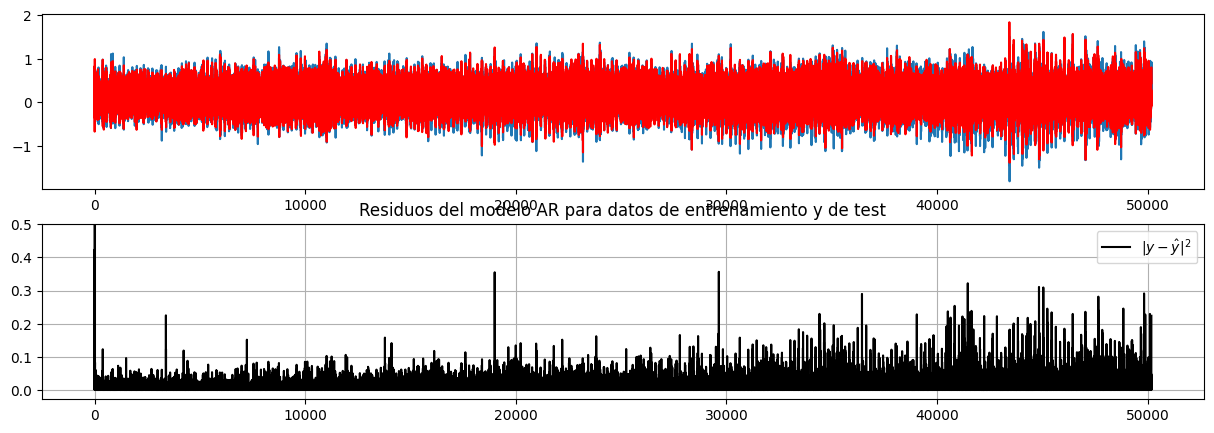

In [7]:
# VISUALIZACIÓN DE LOS RESULTADOS DE LA ESTIMACIÓN

figure(figsize=(15,5))
subplot(2,1,1)
plot(ytest)
plot(yest,color='r')

subplot(2,1,2)
plot((ytest-yest)**2,'k')
grid(True)
legend(['$|y-\hat y|^2$'])
title('Residuos del modelo AR para datos de entrenamiento y de test')
axis(ymax=0.5)



### Espectro paramétrico

Construimos el polinomio $A(z)$ mediante el vector de coeficientes

$$
A = [1, -a_1, -a_2, ..., -a_n] \quad = \quad [1, - {\rm vector\;de\;coeficientes}]
$$

In [8]:
A = hstack((1,-clf.coef_))

Dibujamos el espectro paramétrico, que será el espectro de $\frac{1}{A(z)}$. Usamos el truco de la `fft`. La fft toma un vector cualquiera $v = [v_0, v_1, \dots, v_{N-1}]$ y evalúa

$V_n = \sum_k v_k e^{j n \theta_0 k}$ = $\sum_k v_k e^{j n k 2\pi /N}$ 

Al evaluar $A(\theta)$ en 
$$
\theta =\; 0,\; \theta_0,\; 2\theta_0,\; \dots,\; (n-1) \theta_0
$$ 
¡realmente equivale a evaluar la `fft` de los coeficientes de A!. Si queremos una partición más fina, solo hay que aumentar $N$ mediante la técnica de **zero-padding** (añadir ceros al final). La función `fft(v,N)` añade ceros al final de v hasta completar $N$ elementos, resultando en una partición del rango de $0$ a $f_m$ en $N$ tramos de frecuencia.

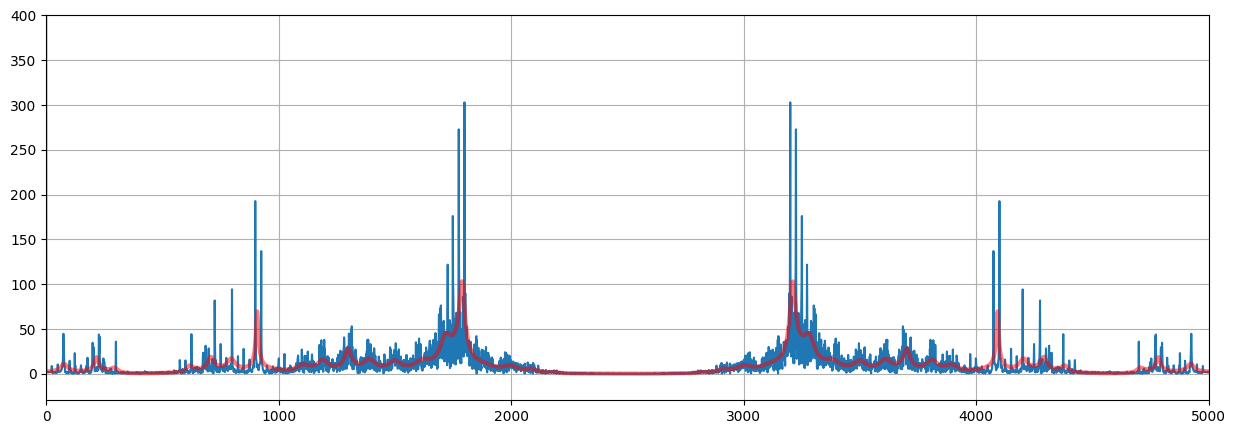

In [9]:
# COTEJAMOS ESPECTRO PARAMÉTRICO CON ESPECTRO NO-PARAMÉTRICO

# elegimos una partición fina de 4096 frecuencias
N = 4096

# el vector de frecuencias será, como siempre
f = arange(0,fm,fm/N)

# y ahora simplemente evaluamos 1/A(e^{j\theta}) en esas N frecuencias
figure(figsize=(15,5))
plot(f,abs(fft(p,N)))
plot(f,1./abs(fft(A,N))*5,color='r',linewidth=3,alpha=0.5)
axis(xmin=0,xmax=fm,ymax=400)
grid(True)

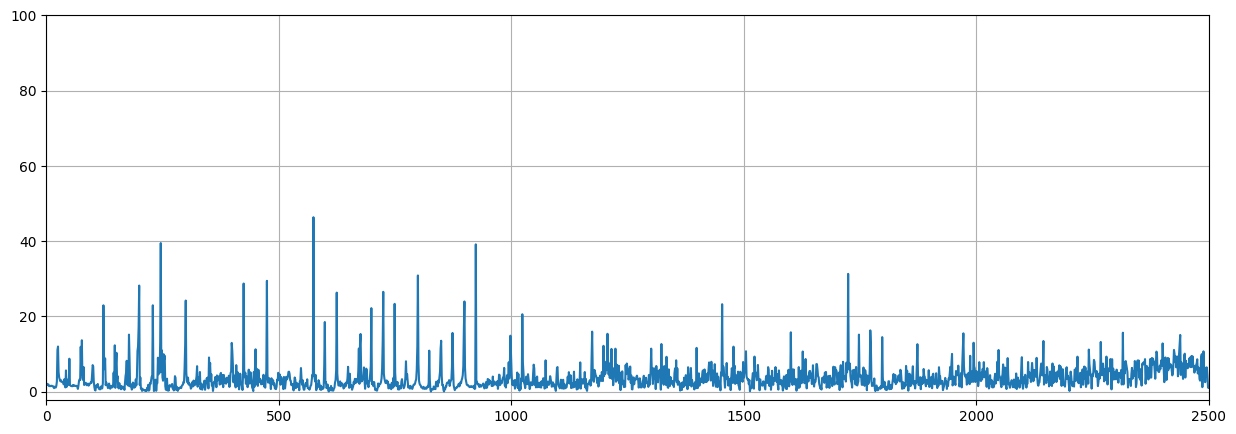

In [10]:
# ESPECTRO EN FRECUENCIA DE LOS RESIDUOS

N = 4096
f = arange(0,fm,fm/N)
figure(figsize=(15,5))
plot(f,abs(fft(ytest-yest,N)))
axis(xmin=0,xmax=2500,ymax=100)
grid(True)

### Estimación AR no lineal y cómputo de residuos

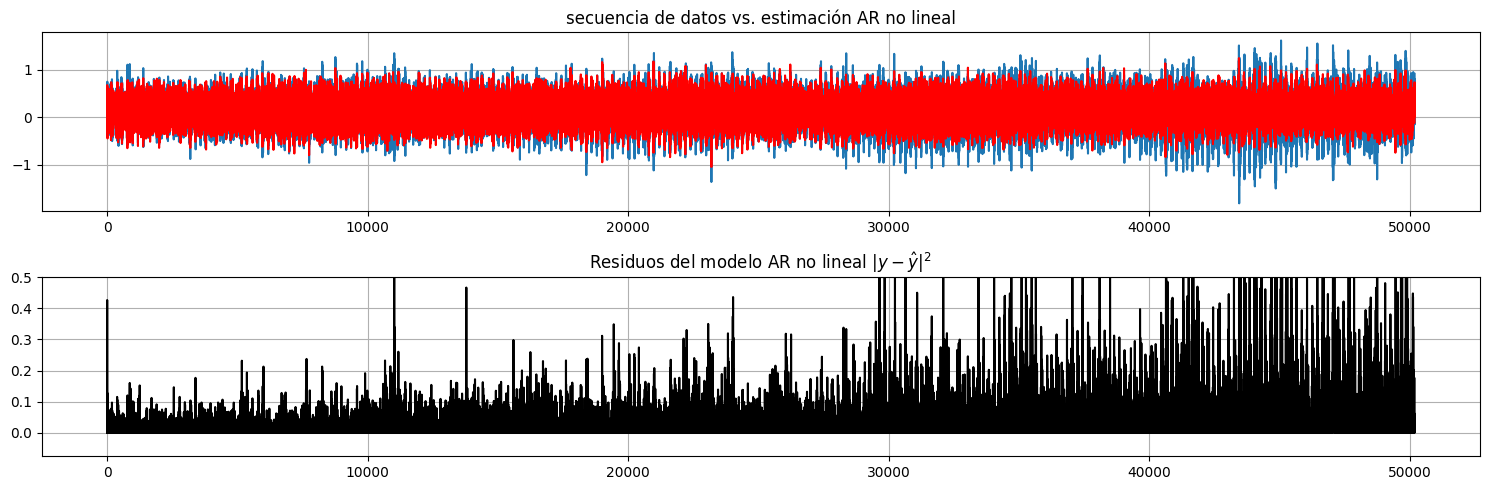

In [11]:
# definimos los parámetros del estimador (alpha es el coef. de regularización)
clf = SVR(C=20,epsilon=0.01)
# ajustamos el modelo para la matriz de datos X (regresores) y la de salidas y
clf.fit(X,y)

# estimamos y en función de X
yest = clf.predict(Xtest)

# visualizamos los resultados de la estimación
figure(figsize=(15,5))
subplot(2,1,1)
plot(ytest)
plot(yest,color='r')
grid(True)
title(u'secuencia de datos vs. estimación AR no lineal')

subplot(2,1,2)
plot((ytest-yest)**2,'k')
grid(True)
title(r'Residuos del modelo AR no lineal $|y - \hat y|^2$')
axis(ymax=0.5)

tight_layout()


<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Modelado AR (estimación de espectro AR y residuos)</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://isa.uniovi.es/~idiaz" property="cc:attributionName" rel="cc:attributionURL">Ignacio Díaz Blanco</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Reconocimiento-CompartirIgual 4.0 Internacional License</a>.